# Úkol č. 3 - Segmentace zákazníků e-shopu
**Deadline úkolu je uveden na [course pages](https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html).**

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu, která jsou v přiloženém souboru `eshop.csv`.

## Pokyny k vypracování

Ve všech bodech zadání uvažujte aktuální datum jako datum poslední transakce (19. 12. 2015), nikoliv dnešek. Tváříme se, že jde o aktuální data.

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

In [1]:
from sklearn.cluster import KMeans
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
import datetime
import seaborn as sns
RS = 42

In [2]:
data = pd.read_csv('eshop.csv', index_col='Customer ID')
data['Date'] = pd.to_datetime(data['Date'])
data.head()

Date  Subtotal         Country
Customer ID                                     
34          2007-06-21      86.0  Czech Republic
38          2007-06-27      38.4  Czech Republic
47          2007-07-02      53.5        Slovakia
61          2007-07-14       7.0  Czech Republic
78          2007-07-21      55.5  Czech Republic

Zacneme konstruovat RFM

In [3]:
rfm = pd.DataFrame()

In [4]:
#Recency
current_date = np.datetime64('2015-12-19')
data['Days'] = current_date -  data['Date']
rfm['recency'] = pd.to_numeric(data.groupby(['Customer ID'])['Days'].min()) / (10**11 * 36 * 24)
rfm['recency'] = rfm['recency'].astype(np.int32)
print(rfm.shape)
rfm.head()

(12829, 1)


recency
Customer ID         
7                311
9               3050
30              3025
34              3103
38              3097

In [5]:
#Frequency
count = data.groupby(['Customer ID'])['Date'].count()
rfm['frequency'] = count
print(rfm.shape)
rfm.head()

(12829, 2)


recency  frequency
Customer ID                    
7                311          3
9               3050          1
30              3025          1
34              3103          1
38              3097          1

In [6]:
#Monetary
monetary = data.groupby(['Customer ID'])['Subtotal'].sum()
rfm['monetary'] = monetary
print(rfm.shape)
rfm.head()

(12829, 3)


recency  frequency  monetary
Customer ID                              
7                311          3     15.54
9               3050          1     13.20
30              3025          1     36.20
34              3103          1     86.00
38              3097          1     38.40

In [7]:
def do_kmeans(X, k):
    est = KMeans(n_clusters=k, random_state=RS)
    est.fit(X)
    return est.labels_, est.cluster_centers_

def plot_all_projections(data, labels, centers):
    x = data['recency']
    y = data['frequency']
    z = data['monetary']
    
    comb = [((x, y), ((0, 'Recency'), (1, 'Frequency'))), 
            ((y, z), ((1, 'Frequency'), (2, 'Monetary'))),
            ((x, z), ((0, 'Recency'), (2, 'Monetary')))]
    
    plt.figure(figsize=(20, 7))
    for i, c in enumerate(comb):
        variables, extra = c
        f, g = variables
        f_inf, g_inf = extra
        plt.subplot(1, 3, i + 1)
        plt.scatter(f, g, c=labels, cmap='brg', alpha=0.4)
        plt.scatter(centers[:, f_inf[0]], centers[:, g_inf[0]], c='black', alpha=1)
        plt.xlabel(f_inf[1])
        plt.ylabel(g_inf[1])
        plt.title(f_inf[1] + ' - ' + g_inf[1])
    plt.show()

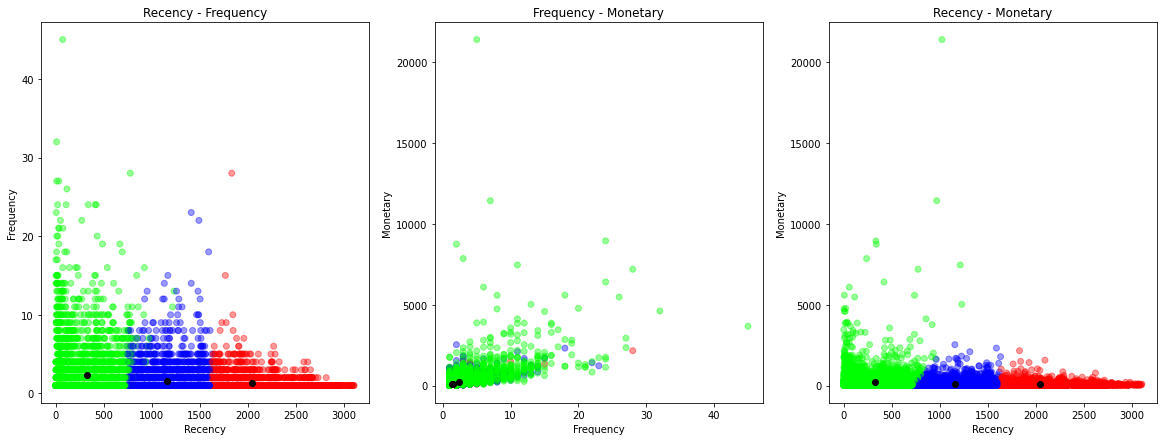

In [8]:
la, ce = do_kmeans(rfm, 3)
plot_all_projections(rfm, la, ce)

K urceni optimalniho k pouzijme funkci z knihovny yellowbrick. Uvnitr se pouziva ["knee-detection algorithm"](https://github.com/arvkevi/kneed)

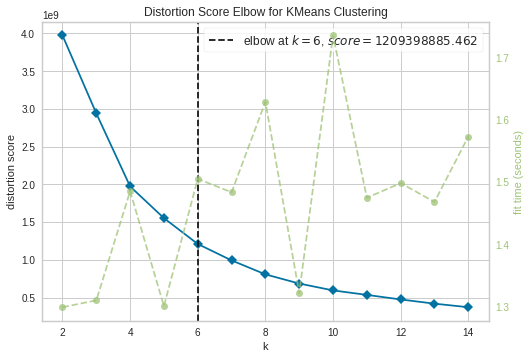

In [9]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=RS)
visualizer = KElbowVisualizer(model, k=(2,15))
visualizer.fit(rfm)
visualizer.show();

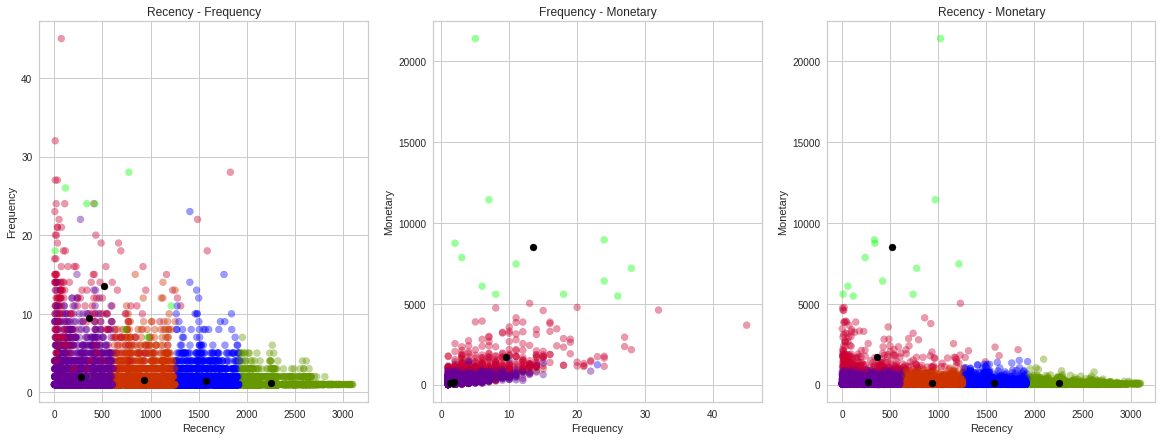

In [10]:
optim_k = 6
lables, centers = do_kmeans(rfm, optim_k)
plot_all_projections(rfm, lables, centers)

Vidime, ze data jsou koncentrovana v jednom miste a bylo by vhodne to preskalovat. Ale musime si poradit s outliery pred skalovanim. Na zacatku prozkoumejme distribuci jednotlivych priznaku. 

Text(0.5, 1.0, 'Monetary log scale')

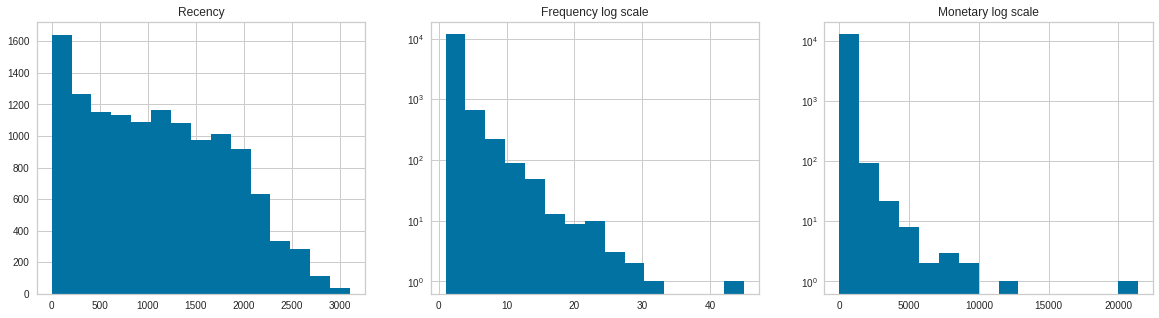

In [11]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
rfm['recency'].hist(bins=15)
plt.title('Recency')

plt.subplot(132)
rfm['frequency'].hist(bins=15, log=True)
plt.title('Frequency log scale')

plt.subplot(133)
rfm['monetary'].hist(bins=15, log=True)
plt.title('Monetary log scale')


Vime, ze Standard  Scaler a MinMaxScaler jsou velmi citlive k outlierum a musime se jich zbavit pred tim, nez aplikovat skalovani. Pouzit rule of thumb nemuzeme pouzit kvuli tomu, ze distribuce hodnot ma exponencialni podobu. Muzeme tedy pouzit box-cox transformaci, cimz transformujeme distribuci na normalni a pak muzeme pouzit Rule of Thumb (outliery budou mimo interval $(mean - 3*std, mean + 3*std)$)

In [12]:
from scipy.stats import boxcox

def find_outliers_boxcox(data):
    outliers_idx = set()
    for col in data.columns:
        ncol = data[col].values + 1
        
        bc_col, bc_lambda = boxcox(ncol)
        bc_col = bc_col - 1
        mean, std = np.mean(bc_col), np.std(bc_col)
        outliersId = [i for i, x in enumerate(bc_col) if x <= mean - 3 * std or x >= mean + 3 * std]
        outliers_idx.update(outliersId)
    print(f'{len(outliers_idx)} outliers found')
    return outliers_idx

In [13]:
outliers = find_outliers_boxcox(rfm)
outliers_idx = rfm.iloc[list(outliers), :].index
rfm.iloc[list(outliers), :].head(10)

34 outliers found


recency  frequency  monetary
Customer ID                              
2867            2075          1      1.68
9393            1036          1      2.49
67              3043          1      2.50
4912            1024          5  21392.38
2449            1230         13   5020.96
14263              9         18   5584.44
7182            1371          1      2.68
4334            1830          1      2.74
11428            703          1      1.18
11154            760          1      2.49

In [14]:
rfm_clean = rfm.drop(outliers_idx.values, axis=0)
rfm_clean.shape, rfm.shape

((12795, 3), (12829, 3))

Data jsou ocistena od outlieru. Ted preskalujeme data pomoci MinMaxScaleru a StandartScaleru a porovanme je. Predtim urcime optimalni k a zkontrolujeme, jestli scaling to zmenil

In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

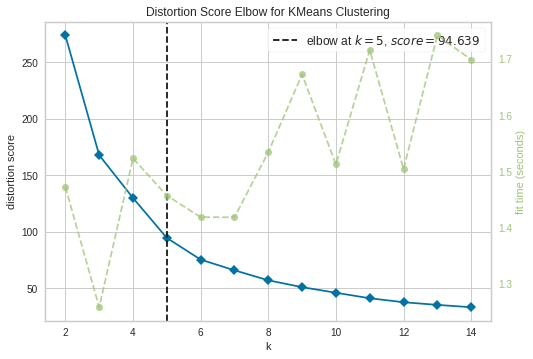

In [16]:
mmscaler = MinMaxScaler()
mm_scaled = pd.DataFrame(mmscaler.fit_transform(rfm_clean), index=rfm_clean.index, columns=rfm_clean.columns)

model = KMeans(random_state=RS)
visualizer = KElbowVisualizer(model, k=(2,15))
visualizer.fit(mm_scaled)
visualizer.show();

Optimalni pocet clusteru se zmenil a to bychom mohli ocekavat. Outlieri mohli lezet velmi daleko od stredu shluku a proto hodnota ztratove funkce pro 6 shluku byla nizsi. Poznamenejme si, ze Distortion score dramaticky klesl.

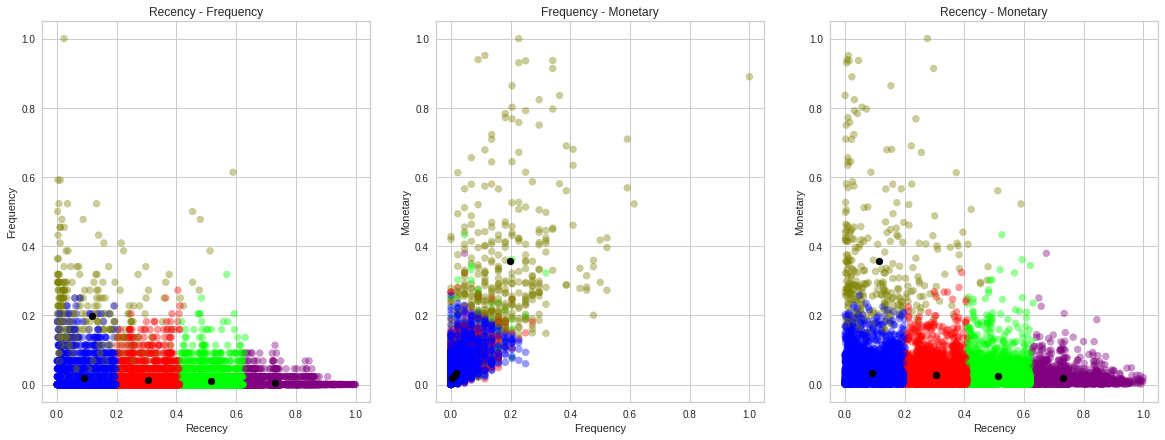

In [17]:
optim_k = 5 
labels, centers = do_kmeans(mm_scaled, optim_k)
plot_all_projections(mm_scaled, labels, centers)

Skalovani nam rozhodne pomohlo. Ted muzeme rozlisit jednotlive shluky a je nejak interpretovat, ale pred tim jeste zkusme aplikovat StandartScaler

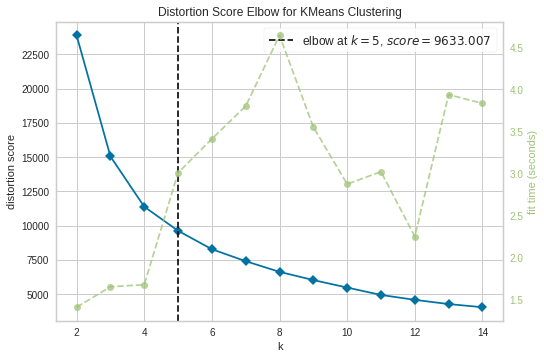

In [18]:
s_scaler = StandardScaler()
s_scaled = pd.DataFrame(s_scaler.fit_transform(rfm_clean), index=rfm_clean.index, columns=rfm_clean.columns)

model = KMeans(random_state=RS)
visualizer = KElbowVisualizer(model, k=(2,15))
visualizer.fit(s_scaled)
visualizer.show();

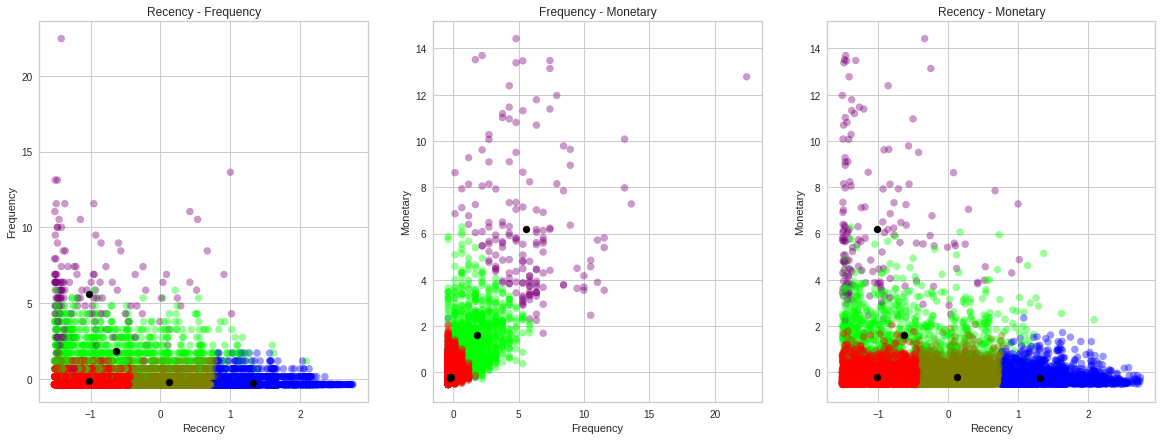

In [19]:
labels, centers = do_kmeans(s_scaled, optim_k)
plot_all_projections(s_scaled, labels, centers)

Podle meho nazoru, po standartizaci jsme dostali jeste lepsi vysledek. Ted vidime hranice jednotlivych shluku a muzeme kazdy shluk interpretovat podle jeho polohy.
- Cerveny - Zakazniky se skoro nulovou frequency, ktere navstivili obchod pred relativne kratkou dobou. T.j. to jsou nove zakazniki, kteri neutraceji hodne penez. Tito zakaznici jeste maji potencial.
- Modry - Jsou to zakaznici, kteri uz pred dlouhou dobou nenavstevovali obchod (nizka frekuency, vysoka recency). Utraceli realtivne malo. Jsou to spise ztraceni zakaznici
- Hnedy(?) - Velmi podobny predchozim. Jediny rozdil je  recency mezi cervenym a modrym shlukem. Na rozdil od modreho shluku, zakaznici s teto skupiny maji vetsi pravdepodobnost navratu.
- Zeleny - to uz jsou zakaznici s vyssi frequency a co je nejdulezitejsi, je to, ze maji vyssi monetary. To jsou velmi dulezita skupina zakazniku, nakupuji casteji a utraceji vic, nez vetsina zakazniku.
- Fialovy - super-star zakaznici. Maji vyskou frequency, relativne nizkou recency a nejvetsi monetary. Pro ucely porovanani stred predchoziho shluku mel monetary ~1.8, tento ma vic nez 6. To je nejdulezitejsi skupina zakazniku pro nas obchod

### Silhouette
Metoda vyhodnocuje jak dobre data byla rozdelena do shluku. Pro zajimavost implementujeme algoritmus a spocitejme Silhouette score vysledneho rozdeleni do clusteru. Implementovat budeme algoritmus podle wikipedii. Silhouette score vzdy v intervalu $[-1, 1]$. Cim vetsi bude bude Silhouette score, tim hustsi a lepe separovane budou clustery 

In [20]:
from sklearn.metrics.pairwise import euclidean_distances 
from sklearn.metrics import silhouette_score

In [21]:
def A(i, cluster):
    """ The mean distance between a sample and all other points in the same cluster"""
    koef = 1 / (len(cluster) - 1)
    sum_dist = np.sum(euclidean_distances(cluster, i.reshape(1, -1)))
    return koef * sum_dist

def B(i, data, labels, our_cluster):
    """The mean distance between a sample and all other points in other clusters"""
    KK = set(labels)
    res = []
    for k in KK:
        if k == our_cluster: # skip our cluster
            continue
        cluster = data[np.where(labels == k)]
        b_i_tmp = 1 / len(cluster) * np.sum(euclidean_distances(cluster, i.reshape(1, -1)))
        res.append(b_i_tmp)
    return np.min(res)
        
def silh_samples(data, labels):
    samples = []
    for i in range(len(data)):
        cluster_idx = labels[i]
        cluster = data[np.where(labels == cluster_idx)]
        a_i = A(data[i], cluster)
        b_i = B(data[i], data, labels, cluster_idx)
        s_i = (b_i - a_i) / np.max([a_i, b_i])
        samples.append(s_i)
    return np.array(samples)
    

def get_silh_score(data, labels):
    datav = data.values
    samples = silh_samples(datav, labels)
    return np.mean(samples)

In [22]:
get_silh_score(s_scaled, labels)

0.3938522296712733

In [23]:
# pro kontrolu z sklearn
silhouette_score(s_scaled, labels)

0.3938522296718355

### Zaver
- kMeans algoritmus spolu s ruznymi techniky preskalovani a odstraneni odlehlych hodnot je mocnym nastrojem na nesupervizovane uceni
- Preskalovani dat je nezbytna zalezitost v uloze shlukovani. Preskalovani nam dramaticky snizilo distortion a shluky samotne se daji lepe po transformaci rozlisovat. Musime ale odstranit odlehle hodnoty, coz jsme museli udelat pomoci Box-Coxove transformace kvuli exponencialnimu rozdeleni priznaku monetary a frequency
- urceni parametru k je uloha slozitejsi a muzeme k ni pristupovat ruznymi smery. My jsme pouzivali distortion metric a elbow algorithm z knihovny `YellowBrick`. Da se to delat na zaklade jinych metrik, jako `Silhouette` skore nebo `Calinski-Harabasz` index.
- V posledni casti notebooku jsme implementovali algoritmus pro vypocet silhouette skore a dostali jsme hodnotu $0.39$ pro vysledne rozdeleni. Tato hodnota neni zadna slava, ale aspon nam rika, ze shluky se prilis neprekryvaji. Vysledne shluky nejsou tak dobre separovane, coz snizuje hodnotu Silhouette skore. 
- Vysledne rozdeleni do shluku nam vyslo smysluplne, ale myslim si, ze cerveny a hnedy shluky se daji sloucit do jednoho, a tak dostaneme 4 hezke skupiny zakazniku, ale podle elbow algoritmu 5 je optimalni pocet shluku a budeme se toho drzet.